# APC Examples
### Warning!
APC is still in development. Kernel panics are possible, especially if the inputs to APC are poorly formed. APC should be run in its own Python virtual environment to prevent loss of data to other running Python processes.  
For information on creating virtual environments please see:  
https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html  
https://docs.python.org/3/library/venv.html   
## APC library requirements
To run this Jupyter notebook you will need the following files in the same directory
1. <b>The APC library</b> built from source. This will be named something like "APC.cp38-win_amd64." "APC" is the library name, "cp38" indicates the library was built for cpython 3.8, and "win_amd64" indicates the library was built for 64bit Windows. The last two parts of the title will vary from system to system.
2. <b>de440.bsp and naif0012.tls</b> These are NAIF kernel files for planetary ephemerides and leap seconds respectively and may be found at https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/ & https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/
3. The EGM2008 <b>matrices</b> binaries folder. A copy is located in the the bin/ folder of this source code. If running this notebook from within bin/, then the matrices folder does not need to be moved.
4. This Jupyter notebook
5. The external python scripts draw_funcs.py and Kepler.py. These contain utility functions and are located in bin/

## Example code requirements
This Jupyter notebook utilizes 3rd party modules to visualize APC's output. To run this notebook install the following modules into your Python virtual environment.
1. <b>NumPy</b> A module primarily used here for manipulating vectors and matrices https://numpy.org/
2. <b>MatplotLib</b> A plotting library that is used for some interactive features https://matplotlib.org
    * <b>ipywidgets</b> Interactive widgets for notebooks
    * <b>ipympl</b> Necessary for widgets to render properly
3. <b>Plotly</b> A plotting library with simultaneous 3D rendering support https://plotly.com/python/
    * <b>nbformat>=4.2</b> is required for Plotly to work in a Jupyter notebook

## Common Errors
If you recieve the message: 
<div>
<b>ModuleNotFoundError:</b> No module named 'APC'
</div>

Ensure the following:
1. Make sure APC was built with the correct version of python. The version used will be the same as the virtual environment that the build command is run in.
2. Ensure that the python kernel that is running this notebook matches the version used to build the APC library
3. Ensure that the APC library is in the same folder as this jupyter notebook.

In [1]:

#External functions
from draw_funcs import *
from Kepler import *
from Utils import out2breaks
#import modules
import sys, os, platform
import APC as APC
import plotly.graph_objects as go
import numpy as np
from IPython.display import display, Math, Latex

if platform.system()=="Windows":
    #avert render bug in windows 10
    import plotly.offline as pyo
    pyo.init_notebook_mode()

### Parallel Benchmarking
This function benchmarks APC by running 1000 LEO trajectories in parallel. This is disabled by default as it may take a long time to run on certain hardware or may slow down the entire system if max_threads is set too high.

In [2]:
Run_Bench=False
max_threads = 4
if Run_Bench:
    out = APC.Benchmark1000(max_threads)
    print("1000 trajectories were propagated in {time:.3f} seconds with {threads} CPU threads.".format(time=out[1],threads=out[0]))
else:
    print("Benchmarking was not run. To run the benchmark replace \"Run_Bench=False\" with \"Run_Bench=True\"")

Benchmarking was not run. To run the benchmark replace "Run_Bench=False" with "Run_Bench=True"


## Propagating a single orbit
This code block takes some orbital elements, converts them to a cartesian state {position, velocity} in ECI, defines some satellite properties and calls SinglePropagate from APC to propagate the orbit over a desired time interval.

In [9]:
title = "lunar orbit"
Re = 1.7380000000000000e+03
q = Re+33
e = .05
a = q/(1-e)
i = 25*np.pi/180
r0,v0 = elms2rv(a,e,i,0,0,0,muMoon)
T = 2*np.pi*np.sqrt(a**3/muMoon)
t0 = 3000
tf = 5*T+t0
r0 = [1838.,         0.,         0.]
v0 = [0.   , 0.74844211, 1.49688755]
#sat props
mass = 1000;
area = 10;
reflectance = 1.5;
Cd = 2.0;
# %%
# #run APC code in single orbit mode with and without perturbations
orbit1 = APC.Orbit("MOON","MOON_PA","J2000")
orbit1.SetPosition0(r0)
orbit1.SetVelocity0(v0)
orbit1.SetIntegrationTime(3000,tf)
# orbit1.SetComputeThirdBody(False)
orbit1.SetComputeHamiltonian(True)
orbit1.SinglePropagate()

## Orbit output
APC returns most propagations as 'Orbit' objects. These objects contain the solution data as well as properties of the orbit. The solutions can be fetched with getter functions of the Orbit object.
### Returning solutions
If the orbit object is assigned to the variable 'orbit1' then these functions can be called with: 

<b>orbit1.getPosition()</b> returns the position as a list of three lists [[X1],[X2],[X3]] where Xi is the list of positions for the ith position coordinate in ECI coordinates over the entire propagation.  
<b>orbit1.getVelocity()</b> returns the position as a list of three lists [[V1],[V2],[V3]] where Vi is the list of velocities for the ith position coordinate in ECI coordinates over the entire propagation.  
<b>orbit1.getPositionX()</b> returns the list of the first coordinate in ECI coordinate of the entire propagation. Also see <b>.getPositionY(), .getPositionZ(), .getVelocityX(), .getVelocityY() & .getVelocityZ(). </b>
<b>orbit1.getTimes()</b> returns the list of times for the returned solution
<b>orbit1.CC</b> is a struct that contains the chebychev coefficient matrices for computing the output position and velocities.


In [10]:
print("By taking the transpose of the position lists with numpy, the list of position vectors [{x0,y0,z0},{x1,y1,z1},...,{xn,yn,zn}] can be returned.")
np.array(orbit1.getPosition()).T

By taking the transpose of the position lists with numpy, the list of position vectors [{x0,y0,z0},{x1,y1,z1},...,{xn,yn,zn}] can be returned.


array([[ 1.83800000e+03,  1.00201097e-14, -8.97294933e-14],
       [ 1.83734676e+03,  2.24507117e+01,  4.49013519e+01],
       [ 1.83538755e+03,  4.48856827e+01,  8.97708535e+01],
       ...,
       [-7.20751476e+02,  8.51797791e+02,  1.61415432e+03],
       [-7.64869231e+02,  8.46139741e+02,  1.59878679e+03],
       [-8.02056346e+02,  8.40937668e+02,  1.58497739e+03]])

## Visualizing the ouput
Below the orbit is visualized around a spherical representation of the Earth. A close-up of the initial position of the orbit is also shown to demonstrate the nodal precession due primarily to the J2 harmonic of Earth's gravity. The functions used to draw these orbits are found in 'draw_funcs.py'

In [11]:
#plot the full orbit
fig = plotOrbit(orbit1)
fig.update_layout(title=title)
fig.show()

#plot a closeup of the intial position
camera = dict(
    up=dict(x=0, y=0, z=1),
    eye=dict(x=.08, y=-.1, z=.05),
    center=dict(x=0,y=0,z=0)
)
diff = 6378
x0 = r0[0]
y0 = r0[1]
z0 = r0[2]
fig.update_layout(
    scene=dict(
    aspectmode = "cube",
    xaxis=dict(range=[x0-diff,x0+diff]),
    yaxis=dict(range=[y0-diff,y0+diff]),
    zaxis=dict(range=[z0-diff,z0+diff])),
    scene_camera=camera, 
    title="Initial Position Close-up")
fig.show()

## Hamiltonian Error
The last figure shows the relative error in the orbiting object's hamiltonian. Conservation of energy dictates that the hamiltonian should not change in a conservative gravity field, but floating point error will cause the orbit's energy to differ slightly ($~10^{-14}  \frac{\Delta J}{J}$) from the model. Additionally propagating with perturbations will show large changes in the hamiltonian over time because the perturbations are either non-conservative (atmospheric drag, solar radiation pressure) or not accounted for in the hamiltonian calculation (solar, lunar gravity perturbations). For highly elliptic orbits the error is largest at periapsis as the orbiting object has the greatest speed and undergoes the largest acceleration at that point. Note that computing the hamiltonian requires more full gravity model calculations which increases computation time. This can be controlled with the kwarg 'compute_hamiltonian' and is set to false by default.

In [6]:
Orbits = np.array(orbit1.getTimes())/T
Hamiltonian = orbit1.getHamiltonian()
H =  go.Figure(go.Scatter(x=Orbits,y=Hamiltonian))
H.update_yaxes(title_text="y-axis in logarithmic scale", type="log")
H.update_layout(title="Hamiltonian for "+title,
xaxis=dict(title="Orbit #"),
yaxis=dict(title=r'Hamiltonian dJ/J',tickformat='.0e'),
)

## Orbital precession
Due to the oblateness of the Earth, orbits tend to precess. This is most visible in highly inclined LEOs over 100s of orbits. The widget below displays individual revolutions of the orbit around the Earth and the slider moves the orbit further into the future, which shows how the orbit precesses. Sometimes (especially when installing ipywidgets for the first time), the Jupyter server needs to be restarted before the widgets will appear.

In [7]:
# """Setup topdown view"""
# %matplotlib widget
# orbits_x, orbits_y,orbits_t, elms = out2breaks(orbit1)
# trace2d = go.Scatter(x=orbit1.getPositionX(),y=orbit1.getPositionY(),mode = 'lines')
# trace2 = plot_circle(6378)
# fig2d = go.Figure(data=[trace2d,trace2])
# fig2d.layout.xaxis.range=(-42500,8500)
# fig2d.layout.yaxis.range=(-20000,20000)
# fig2d.update_layout(
#     autosize = False,
#     width = 600,
#     showlegend=False,
#     xaxis_constrain = 'domain',
#     yaxis_scaleanchor= 'x',
#     margin=dict(l=10, r=10, t=10, b=10))

# import plotly.graph_objs as go
# import plotly.offline as py
# import plotly
# from ipywidgets import interactive, HBox, VBox, widgets, interact

# Xs = orbit1.getPosition()
# clamp = 10000
# # load fig
# fig = fig2d
# # create FigureWidget from fig
# f = go.FigureWidget(data=fig.data, layout=fig.layout)
# f.add_trace(plot_circle(6378,opacity=1))
# xmin = max(min(min(Xs[0]),-8000),-clamp)
# ymin = max(min(min(Xs[1]),-8000),-clamp)
# ymax = min(max(max(Xs[1]),8000),clamp)
# xmax = min(max(max(Xs[0]),8000),clamp)
# f.layout.yaxis.range=[ymin,ymax]
# f.layout.xaxis.range=[xmin,xmax]
# f.layout.xaxis.title="X (km)"
# f.layout.yaxis.title="Y (km)"
# f.layout.title = "77 Deg Gravity Polar View Nodal Precession t={:.2f} hours<br><sup>a={}, e={}, i={}</sup>".format(0,a,e,180*i/np.pi)
# f.update_layout(title_x=0.5)
# f.layout.margin=dict(l=20,r=20,t=60,b=20)
# f.layout.height = 800
# f.layout.width = 800

# slider = widgets.IntSlider(
#     min=0,
#     max=len(orbits_y)-1,
#     step=1,
#     readout=True,
#     description='Orbit')
# slider.layout.width = '800px'

# # our function that will modify the xaxis range
# def update_range(y):
#     f.plotly_restyle({'x':[orbits_x[y]],'y':[orbits_y[y]]},0)
#     f.layout.yaxis.range=[ymin,ymax]
#     f.layout.xaxis.range=[xmin,xmax]
#     title = "77 Deg Gravity Polar View Nodal Precession t={:.2f} hours<br><sup>a={:.2f} km, e={:.3f}, i={:.2f}°</sup>".format(orbits_t[y][0]/3600,a,e,i*180/np.pi)
#     f.update_layout(title_text = title, title_x=0.5)
#     f.show
    
# vb = VBox((f, interactive(update_range,y=slider)))
# vb.layout.align_items = 'flex-start'
# vb

## Save the widget
The following code block allows the widget above to be exported as a series of images to be constructed as a video or animated gif. This process requires the Python module of Kaleido called "Python-Kaleido."

In [8]:
# save_image=False
# if not os.path.exists("images"):
#         os.mkdir("images")

# for k in np.arange(0,len(orbits_y)):
#     update_range(k)
#     if save_image:
#         f.write_image('images/fig{}.png'.format(k))

-22144468.988888897


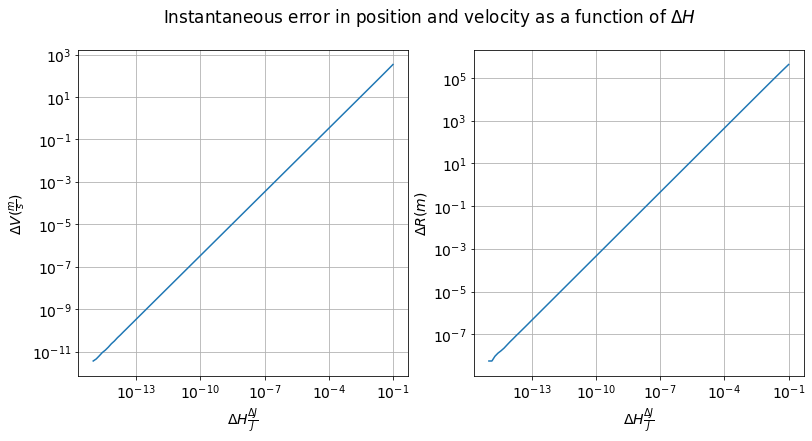

In [63]:
muEarth = 398600.4418
r,v = elms2rv(9000,0,i,0,0,0,muEarth)
r=1000*r
v=1000*v
muE = 398600.4418*1e9
H0 = 1/2*np.linalg.norm(v)**2-muE/np.linalg.norm(r)
print(H0)
dHs = np.logspace(-15,-1,100)
dV = []
dR = []

for dH in dHs:
    H = (1+dH)*H0
    dv =np.linalg.norm(v)-np.sqrt(2*(H+muE/np.linalg.norm(r)))
    dr = np.linalg.norm(r)-muE/(-H+1/2*np.linalg.norm(v)**2)
    dV.append(dv)
    dR.append(dr)
#increase plot font size
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.loglog(dHs,dV)
plt.xlabel(r'$\Delta H \frac{\Delta J}{J}$')
plt.ylabel(r'$\Delta V (\frac{m}{s})$')
plt.grid()
plt.subplot(122)
plt.loglog(dHs,dR)
plt.xlabel(r'$\Delta H \frac{\Delta J}{J}$')
plt.ylabel(r'$\Delta R (m)$')
plt.grid()
plt.suptitle('Instantaneous error in position and velocity as a function of $\Delta H$')
plt.show()

